In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/my_PJME_MW.csv')

объединим дату и время для индекса

In [3]:
df.loc[:,'DateTime'] = pd.to_datetime(df.Date.astype(str)+' '+df.Time.astype(str))
df = df.set_index('DateTime')
df.head()

,Date,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
DateTime,,,,,,,,,,,,,,
2002-01-01 01:00:00,2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


/home/yzi/projects/gb_ml_bysiness/env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


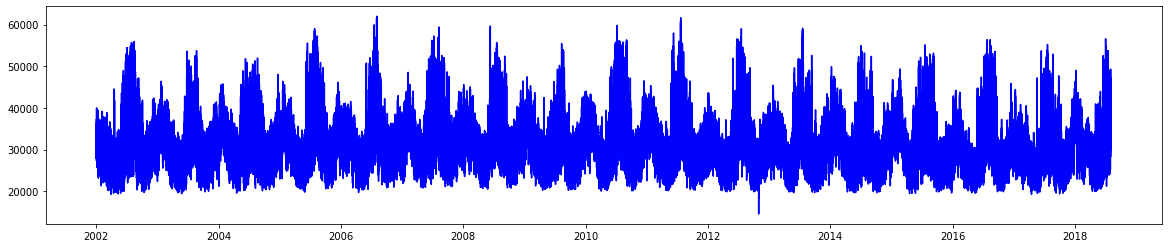

In [4]:
plt.figure(figsize =(20,4))
plt.plot(df.index, df['PJME_MW'],'b')
plt.show()

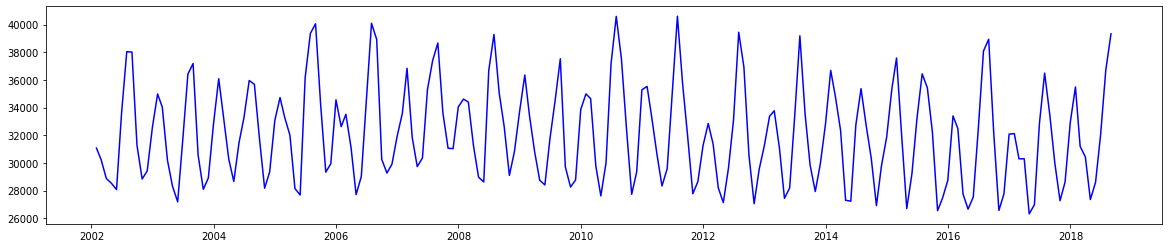

In [5]:
df_m = df.resample('M').mean()
plt.figure(figsize =(20,4))
plt.plot(df_m.index, df_m['PJME_MW'],'b')
plt.show()

Хорошо заметна годовая сезонная зависимость.

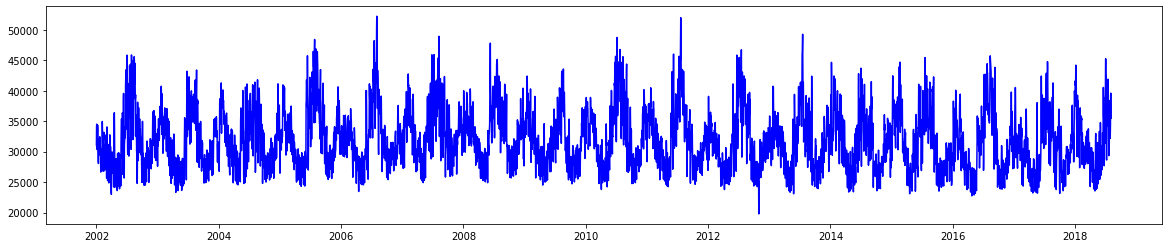

In [6]:
df_d = df.resample('D').mean()
plt.figure(figsize =(20,4))
plt.plot(df_d.index, df_d['PJME_MW'],'b')
plt.show()

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [8]:
data_exp_1 = exponential_smoothing(df_d['PJME_MW'], 0.05)

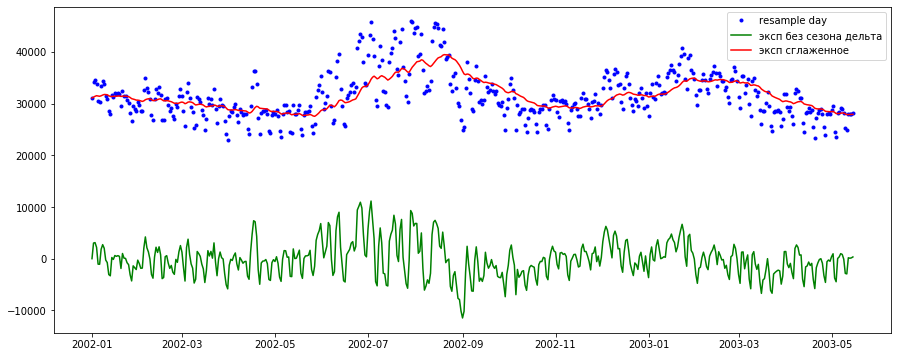

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(df_d.index[:500], df_d['PJME_MW'].values[:500], 
         '.b', label='resample day')
plt.plot(df_d.index[:500], df_d['PJME_MW'].values[:500] - data_exp_1[:500], 
         color = 'green', label="эксп без сезона дельта")
plt.plot(df_d.index[:500], data_exp_1[:500], 
         color = 'red', label="эксп сглаженное")
plt.legend();

In [10]:
df_exp_1 = pd.DataFrame({'value': data_exp_1}, index=df_d.index)
df_exp_1.head()

,value
DateTime,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


добавляем историю в векторы

In [11]:
def comb_prev_vals(df, hist=5):
    for x in range(1, hist):
        df[f't{x}']=0
        df.iloc[x:,x]=df.iloc[:-x,0].values
    df.fillna(0)
    return df

In [12]:
df_exp_1 = comb_prev_vals(df_exp_1, 10)
df_exp_1.head(10)

,value,t1,t2,t3,t4,t5,t6,t7,t8,t9
DateTime,,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.000000,0.00000
2002-01-06,31406.309057,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.00000
2002-01-07,31502.685270,31406.309057,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.00000
2002-01-08,31645.696840,31502.685270,31406.309057,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.00000
2002-01-09,31752.220331,31645.696840,31502.685270,31406.309057,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.00000


In [13]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('DateTime') <= split_date].copy(), \
           data.loc[data.index.get_level_values('DateTime') >  split_date].copy()

In [14]:
X_train, X_test = split_data(df_exp_1, '2017-01-01')

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
def model_and_prediction(h=1):
    X_train_1 = X_train.iloc[:-h,:]
    y_train_1 = X_train[df_exp_1.columns[0]].values[h:]
    X_test_1 = X_test.iloc[:-h,:]
    y_test_1 = X_test[df_exp_1.columns[0]].values[h:]
    
    stsc = StandardScaler()
    
    X_train_1 = stsc.fit_transform(X_train_1)
    X_test_1 = stsc.transform(X_test_1)
    
    plt.figure(figsize=(15, 7))
    plt.xlabel('Время')
    plt.ylabel('Потребление энергии')
    plt.plot(X_train.index.get_level_values('DateTime'), X_train[df_exp_1.columns[0]], label='train' )
    plt.plot(X_test.index.get_level_values('DateTime'), X_test[df_exp_1.columns[0]], label='test')
    plt.title('Тренировочные и тестовые данные')
    plt.legend();
    
    model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)
    model_gb.fit(X_train_1, y_train_1) 
    
    y_test = model_gb.predict(X_test_1)
    
    plt.figure(figsize=(15, 6))

    plt.xlabel('Время')
    plt.ylabel('Потребление энергии')
    plt.plot(X_test.index[h:h+50], y_test[:50], label='Предсказание')
    plt.plot(X_test.index[h:h+50], y_test_1[:50], label='test data')

    plt.legend()
    plt.show()

    er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test)

    print('ошибка градиентного бустинга :  ', er_g_1, '%')

#### Модель и прогноз для h=1

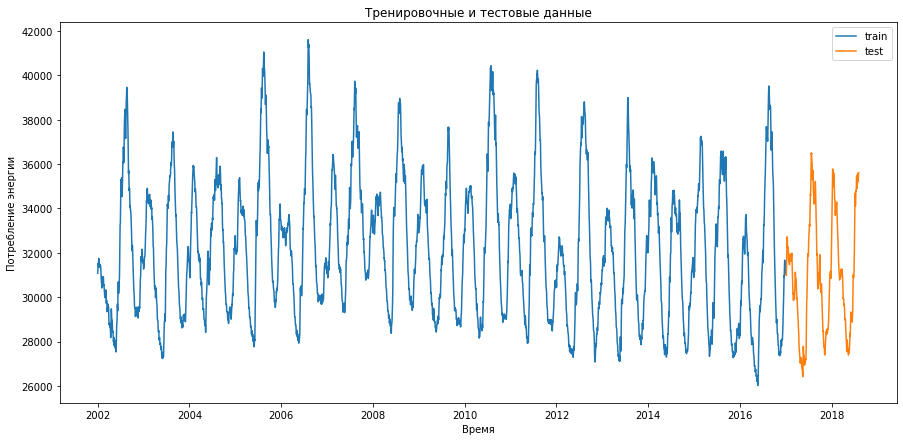

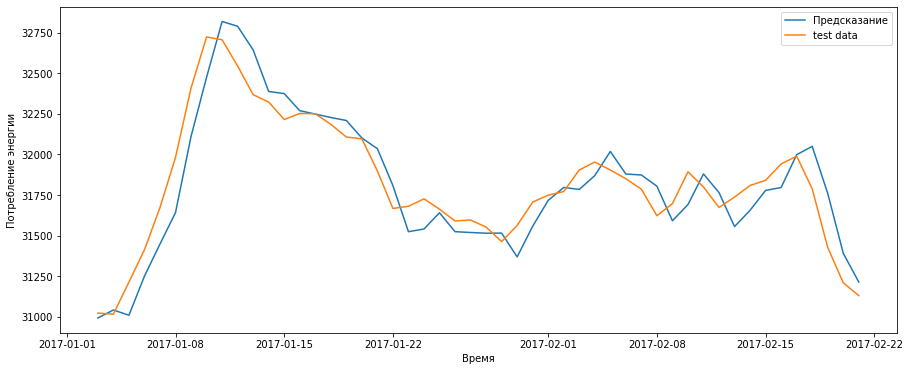

ошибка градиентного бустинга :   0.4160594113318614 %


In [40]:
model_and_prediction()

#### Модель и прогноз для h=5

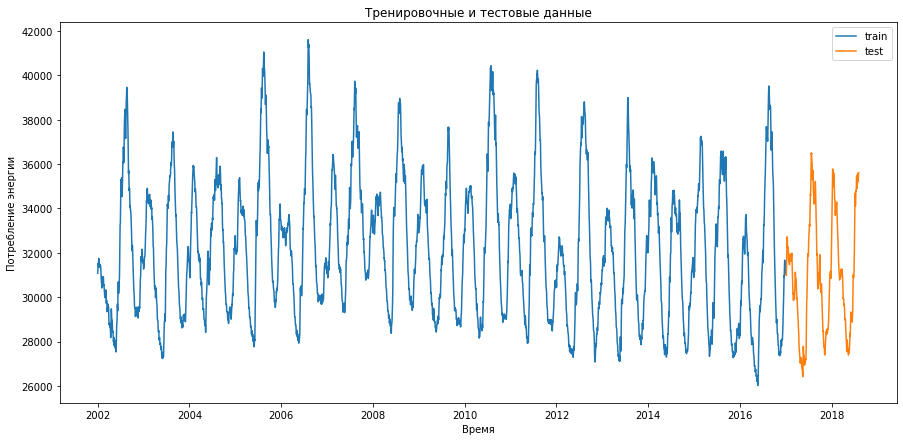

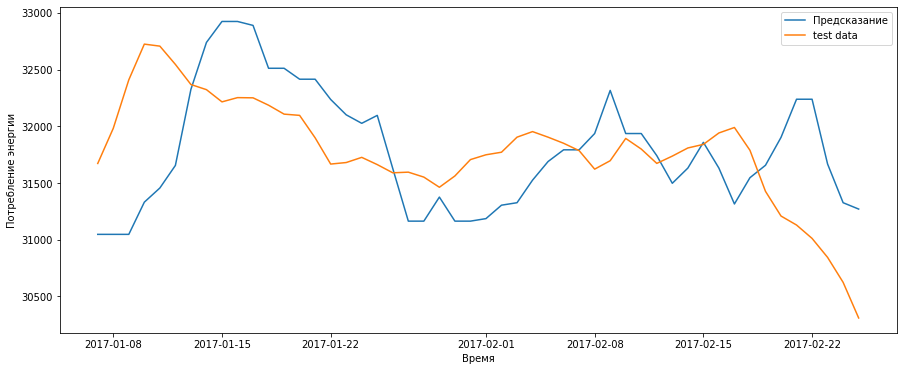

ошибка градиентного бустинга :   1.6580773521887637 %


In [43]:
model_and_prediction(5)

#### Модель и прогноз для h=10

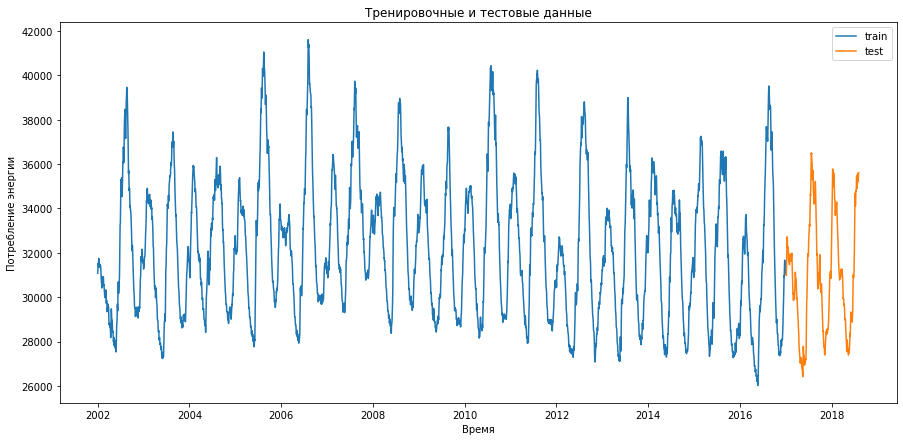

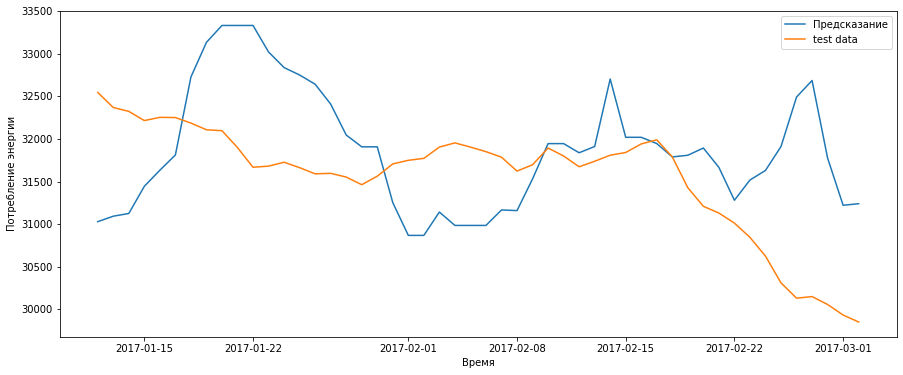

ошибка градиентного бустинга :   2.781106335667393 %


In [41]:
model_and_prediction(10)

с увеличением h ошибка растет